## Introduction 

L'objectif de ce projet est d'observer s'il existe des "déserts sportifs", lieux en France où les infrastrcutures sportives manquent. 

La question sera alors d'essayer d'expliquer ces déserts sportifs, que ce soit par des raisons économiques ou politiques. 

Nous allons tenter d'expliquer la répartition géographique des infrastructures sportives en France métropolitaine car en tant que grands sportifs, nous avons l'habitude de parcourir les terrains. C'est pourquoi nous avons voulu prendre de la hauteur pour analyser la France comme un unique et immense terrain de jeu, afin de comprendre si les règles d'accès aux infrastructures sont les mêmes pour tous.


### I/ Importation des modules

In [1]:
#Installation des modules
!pip install py7zr geopandas openpyxl tqdm s3fs --quiet
!pip install PyYAML xlrd --quiet
!pip install cartiflette --quiet
!pip install contextily --quiet
!pip install folium --quiet
!pip install nb-clean --quiet
!pip install statsmodels --quiet

In [2]:
#Importation des modules
import numpy as np
import numpy.linalg as al
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
from cartiflette import carti_download
import requests
import io
import zipfile
import folium
from folium.plugins import HeatMap
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

 ### II/ Création de la base de données

Importons les trois jeux de données qui nous intéressent :
- La base de données principale : localisation des infrastructures sportives en France
- Une base de données avec des informations économiques et démographiques sur les communes
- Une base de données comportant des informations politiques sur les communes (résultat du second tour des législatives 2024)

In [3]:
%run src/import.py

In [4]:
#Visualisation de la base de données principale
equipement.head(3)

,equip_numero,inst_numero,inst_enqu_date,inst_nom,inst_siret,inst_adresse,inst_cp,new_name,new_code,inst_part_type_filter,...,equip_pshs_trib,equip_pshs_vest,equip_x,equip_y,inst_part_type,aps_name,equip_qpv,equip_qpv_200m,categorie,gen_2024fin_labellisation
0,E002I561880004,I561880004,2025-03-31,Complexe sportif Guy Corlay,2.156019e+13,4 Rue Pierre de Coubertin,56310,Quistinic,56188,Complexe sportif,...,False,False,-3.140050,47.905720,"[""Complexe sportif""]",Sports boules,NaN,NaN,NaN,NaN
1,E008I850390001,I850390001,2025-03-31,COMPLEXE SPORTIF,NaN,rue des salles,85530,La Bruffière,85039,Complexe sportif,...,False,False,-1.194829,47.015972,"[""Complexe sportif""]","Cyclotourisme,Vtt (Cross Country/ Descente/ Tr...",NaN,NaN,NaN,NaN
2,E001I741410001,I741410001,2025-03-31,DEBARQUEMENT PARCOURS DU FIER,NaN,LA CROIX,74150,Hauteville-sur-Fier,74141,NaN,...,False,False,5.970830,45.901670,NaN,"Descente,Rodéo/Freestyle",NaN,NaN,NaN,NaN


In [5]:
#Visualisation de la base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P16_POP,SUPERF,NAIS1621,DECE1621,P22_MEN,NAISD24,DECESD24,P22_LOG,...,P22_CHOM1564,P22_ACT1564,ETTOT23,ETAZ23,ETBE23,ETFZ23,ETGU23,ETOQ23,ETTEF123,ETTEFP1023
0,01001,859.0,767.0,15.95,51.0,33.0,354.000000,8.0,4.0,379.000000,...,28.000000,431.000000,16.0,4.0,0.0,3.0,7.0,2.0,13.0,2.0
1,01002,273.0,243.0,9.15,14.0,11.0,121.000000,1.0,4.0,175.000000,...,2.000000,133.000000,4.0,1.0,0.0,0.0,2.0,1.0,3.0,0.0
2,01004,15554.0,14081.0,24.60,1325.0,808.0,7107.012476,175.0,118.0,7973.370708,...,1005.744641,7479.600207,599.0,1.0,31.0,61.0,420.0,86.0,435.0,132.0


In [6]:
#Visualisation de la base de données politique
legislatives2.head(3)

,Code département,Libellé département,Code commune,Libellé commune,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,...,Elu 17,Numéro de panneau 18,Nuance candidat 18,Nom candidat 18,Prénom candidat 18,Sexe candidat 18,Voix 18,% Voix/inscrits 18,% Voix/exprimés 18,Elu 18
0,01,Ain,01001,L'Abergement-Clémenciat,662,494,"74,62%",168,"25,38%",476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,Ain,01002,L'Abergement-de-Varey,228,187,"82,02%",41,"17,98%",166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,Ain,01004,Ambérieu-en-Bugey,8745,5887,"67,32%",2858,"32,68%",5348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sur les plus de 300 colonnes disponibles, on conserve celles qui nous intéressent. 

In [7]:
%run src/lavage.py
from src.lavage import nettoyer_donnees

equipement, df_communes, legislatives2 = nettoyer_donnees(equipement, df_communes, legislatives2)

Nettoyage terminé : colonnes filtrées et variables binaires créées.


In [8]:
#Visualisation nouvelle base de données principale
equipement.head(3)

,inst_cp,new_name,new_code,dep_code,aps_name,dens_lib,equip_type_name,equip_x,equip_y
0,56310,Quistinic,56188,56,Sports boules,Rural à habitat dispersé,Terrain de boules,-3.140050,47.905720
1,85530,La Bruffière,85039,85,"Cyclotourisme,Vtt (Cross Country/ Descente/ Tr...",Bourgs ruraux,Boucle de randonnée,-1.194829,47.015972
2,74150,Hauteville-sur-Fier,74141,74,"Descente,Rodéo/Freestyle",Bourgs ruraux,Point d'embarquement et de débarquement isolé,5.970830,45.901670


In [9]:
#Visualisation nouvelle base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564
0,01001,859.0,354.000000,25820,s,28.000000
1,01002,273.0,121.000000,24480,s,2.000000
2,01004,15554.0,7107.012476,21660,"17,0",1005.744641


In [10]:
#Visualisation nouvelle base de données politique
legislatives2.head(3)

,Code commune,Libellé commune,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4
0,01001,L'Abergement-Clémenciat,ENS,RN,NaN,NaN,0,1,0,0
1,01002,L'Abergement-de-Varey,UG,UXD,NaN,NaN,0,1,0,0
2,01004,Ambérieu-en-Bugey,UG,UXD,NaN,NaN,0,1,0,0


Les noms des colonnes étant des fois compliqués à comprendre, voici des dictionnaires afin de comprendre la signification de chaque colonne. 

In [11]:
%run src/Dictionnaires.py

Dictionaire équipement:


,Variable,Description
0,inst_cp,Code postal de la commune
1,new_name,Nom de la commune
2,new_code,Code INSEE de la commune
3,dep_code,Code du département
4,aps_name,Sport
5,dens_lib,Densité de la commune
6,equip_type_name,Type d'infrastructure sportive
7,equip_x,Longitude
8,equip_y,Latitude



Dictionnaire communes:


,Variable,Description
0,CODGEO,Code INSEE de la commune
1,P22_POP,Population en 2022
2,P22_MEN,Nombre de ménages en 2022
3,MED21,Médiane du niveau de vie en 2021
4,TP6021,Taux de pauvreté en 2021
5,P22_CHOM1564,Nombre de chômeurs de 15 à 64 ans en 2022



Dictionnaire politique:


,Variable,Description
0,Code commune,Code INSEE de la commune
1,Nuance candidat,Parti politique du candidat
2,Elu,"Variable binaire égale à 1 si le candidat a été élu, 0 sinon"


In [12]:
#On souhaite créer une variable "Nuance politique du candidat élu" pour notre base de données finale

def get_nuance_elu(row):
    """
    Retourne la nuance du candidat élu pour la commune de la ligne "row"
    """
    if row['Elu 1']:
        return row['Nuance candidat 1']
    elif row['Elu 2']:
        return row['Nuance candidat 2']
    elif row['Elu 3']:
        return row['Nuance candidat 3']
    elif row['Elu 4']:
        return row['Nuance candidat 4']
    else:
        return np.nan

legislatives2['Nuance candidat élu'] = legislatives2.apply(get_nuance_elu, axis=1)

In [13]:
legislatives2.head(3)

,Code commune,Libellé commune,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4,Nuance candidat élu
0,01001,L'Abergement-Clémenciat,ENS,RN,NaN,NaN,0,1,0,0,RN
1,01002,L'Abergement-de-Varey,UG,UXD,NaN,NaN,0,1,0,0,UXD
2,01004,Ambérieu-en-Bugey,UG,UXD,NaN,NaN,0,1,0,0,UXD


In [14]:
#On garde seulement la nuance du candidat élu, ce qui nous intéresse ici afin de potentiellement expliquer 
#le rôle de la politique 

cols = ["Code commune", "Nuance candidat élu"]
legislatives2 = legislatives2[cols]
legislatives2.head(3)

,Code commune,Nuance candidat élu
0,01001,RN
1,01002,UXD
2,01004,UXD


In [15]:
#On réunit tous les jeux de données pour obtenir notre jeu de données final

df_communes = df_communes.rename(columns={"CODGEO": "new_code"})
legislatives2 = legislatives2.rename(columns={"Code commune": "new_code"}) #On renomme les colonnes pour concaténer

df_final = (
    equipement
    .merge(df_communes, on="new_code", how="left")
    .merge(legislatives2, on="new_code", how="left")
)

df_final.head(12)

,inst_cp,new_name,new_code,dep_code,aps_name,dens_lib,equip_type_name,equip_x,equip_y,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu
0,56310,Quistinic,56188,56,Sports boules,Rural à habitat dispersé,Terrain de boules,-3.140050,47.905720,1423.0,659.335773,21690,s,83.202522,ENS
1,85530,La Bruffière,85039,85,"Cyclotourisme,Vtt (Cross Country/ Descente/ Trial/ Rallye/ Four Cross) / Vélo trial",Bourgs ruraux,Boucle de randonnée,-1.194829,47.015972,4015.0,1653.751934,22550,"6,0",93.093343,DVD
2,74150,Hauteville-sur-Fier,74141,74,"Descente,Rodéo/Freestyle",Bourgs ruraux,Point d'embarquement et de débarquement isolé,5.970830,45.901670,1074.0,421.436761,27970,s,20.146633,ENS
3,56500,Radenac,56189,56,"Cyclotourisme,Randonnée pédestre",Rural à habitat dispersé,Boucle de randonnée,-2.716366,47.958511,1067.0,479.000000,21840,s,40.000000,ENS
4,85140,Chauché,85064,85,Pétanque et jeu provencal,Rural à habitat dispersé,Terrain de pétanque,-1.269200,46.828800,2559.0,1033.831376,23180,s,64.413756,DVD
5,74540,Héry-sur-Alby,74142,74,Gymnastique volontaire,Rural à habitat dispersé,Salles polyvalentes / des fêtes / non spécialisées,6.013060,45.796940,973.0,387.420997,28190,s,42.074498,ENS
6,56500,Réguiny,56190,56,Pétanque et jeu provencal,Bourgs ruraux,Terrain de pétanque,-2.744440,47.978910,1944.0,864.959415,21480,s,63.612679,ENS
7,85220,Coëx,85070,85,"Boules traditionnelles,Pétanque et jeu provencal",Bourgs ruraux,Terrain de boules,-1.767240,46.696510,3416.0,1532.843653,21870,"10,0",166.903342,ENS
8,74310,Les Houches,74143,74,Parapente,Petites villes,Aire de décollage,6.751110,45.893060,3529.0,1626.000000,24290,"16,0",93.000000,ENS
9,56500,Réguiny,56190,56,"Cyclotourisme,Randonnée pédestre,Randonnée équestre,Vtt (Cross Country/ Descente/ Trial/ Rallye/ Four Cross) / Vélo trial",Bourgs ruraux,Boucle de randonnée,-2.739103,47.970204,1944.0,864.959415,21480,s,63.612679,ENS


In [16]:
#On supprime des lignes doublons
df_final = df_final.drop_duplicates()

In [17]:
#Maintenant, on va regarder le type des colonnes pour mettre les variables dans le format qui nous arrange

print(df_final.dtypes)

inst_cp                  int64
new_name                object
new_code                object
dep_code                object
aps_name                object
dens_lib                object
equip_type_name         object
equip_x                float64
equip_y                float64
P22_POP                float64
P22_MEN                float64
MED21                   object
TP6021                  object
P22_CHOM1564           float64
Nuance candidat élu     object
dtype: object


In [18]:
#On va convertir les Code de départements en entier

#On fait le choix de Remplacer 2A et 2B par 96 et 97
df_final['dep_code'] = df_final['dep_code'].replace({'2A': '96', '2B': '97'})

#On convertit en entier, coerce nous permet de gérer les erreurs en cas de valeur manquante
df_final['dep_code'] = pd.to_numeric(df_final['dep_code'], errors='coerce').astype('Int64')

In [19]:
#Finalement, on ne conserve que les données sur la France métropolitaine, afin de faciliter les 
#représentations graphiques (cartes)

df_final = df_final[1 <= (df_final['dep_code'] <= 97)]

In [20]:
df_final['MED21'] = pd.to_numeric(df_final['MED21'], errors='coerce').astype('Int64')

### III/Statistiques Descriptives

In [21]:
#On récupère le fond de carte de la france métropolitaine


#Téléchargement de toute la France avec les DROM
gdf = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

#Filtrer pour ne garder que la métropole (exclure les DROM)
departements_drom = ["971", "972", "973", "974", "975", "976"]
gdf = gdf[~gdf['INSEE_DEP'].isin(departements_drom)]

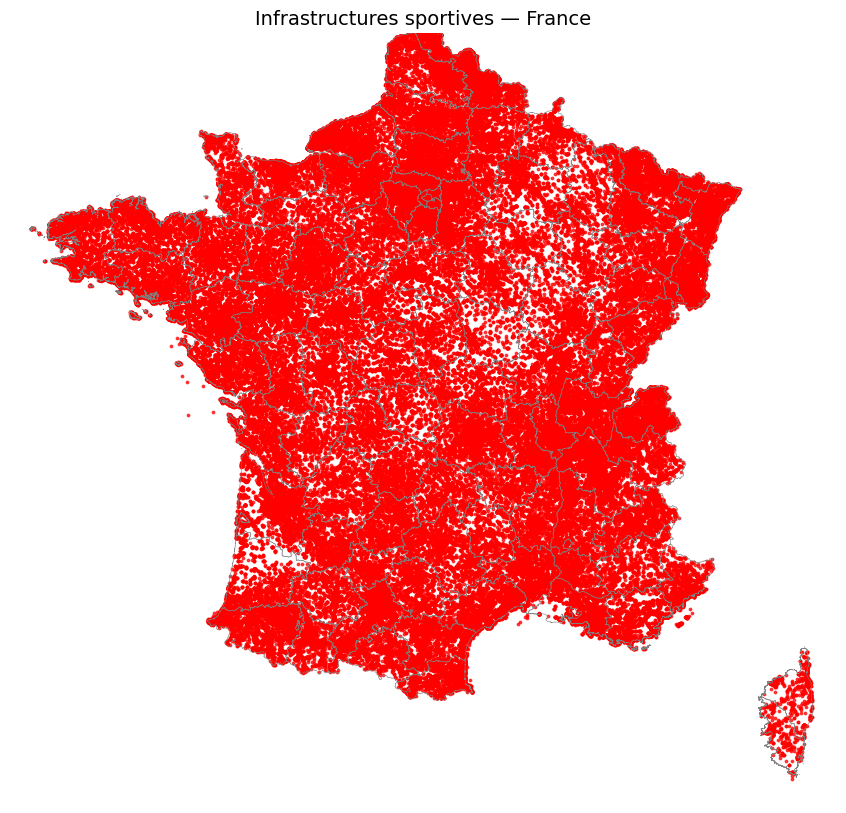

In [22]:
gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["equip_x"], df_final["equip_y"]),
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(20, 10))
gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.savefig('docs/premiere_carte.png', dpi=300, bbox_inches='tight')

On voit que le schéma de la "diagonale du vide" semble se reproduire avec les infrastructures sportives.

La densité des infrastructures sportives en Corse semble moins importante qu'en France métropolitaine.

In [23]:
#Carte de chaleur 


df = df_final.copy().dropna(subset=['equip_x', 'equip_y'])  #Supression des valeurs manquantes

#Création de la carte, centrée sur la France
calor = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='CartoDB positron'
)

#Récupération des données géographiques
heat_data = [[row['equip_y'], row['equip_x']] for idx, row in df.iterrows()]


#On complète la carte
HeatMap(
    heat_data,
    radius=15,           # Rayon de chaque point
    blur=20,             # Flou pour adoucir
    max_zoom=13,         # Zoom maximum
    gradient={            # Dégradé de couleurs personnalisé
        0.0: 'blue',
        0.3: 'lime',
        0.5: 'yellow',
        0.7: 'orange',
        1.0: 'red'
    }
).add_to(calor)
calor.save('docs/heatmap_toutes_infrastructures.html') #On sauvegarde la carte

Sur cette carte, on remarque que la densité des infrastructures est plus élevée en Ile de France. 
Il pourra être intéressant de comprendre pourquoi dans la partie modélisation. 

In [24]:
def carte_interactive(df, info_couleur, titre_legende, info_survol, chemin_sauvegarde):
    """

    Fonction qui permet de créer et d'afficher des cartes interactives
    
    Paramètres
    ----------
    df : DataFrame
        DataFrame contenant les informations à représenter sur la carte interactive
        
    info_couleur : str
        Nom de la variable du DataFrame selon laquelle on veut colorer la carte

    titre_legende : str
        Titre de la légende de couleurs

    info_survol : list
        Liste des variables (str) pour lesquelles on veut afficher les informations au survol de la souris

    chemin_sauvegarde : str
        Endroit où l'on veut sauvegarder la carte
        
    """

    #On copie le fond de carte pour ne pas le modifier directement
    gd = gdf.copy()
    
    
    #Fusion des données selon les codes de département
    gd = gd.merge(                 
    infra_par_dept, 
    left_on='INSEE_DEP', 
    right_on='dep_code', 
    how='left'
    )

    #Création de la carte, centrée sur la France
    m = folium.Map(
        location=[46.5, 2.5],
        zoom_start=6,
        tiles='CartoDB positron'
    )

    #On complète la carte
    folium.Choropleth(
        geo_data=gd,
        name='choropleth',
        data=df,
        columns=['dep_code', info_couleur],
        key_on='feature.properties.INSEE_DEP',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=titre_legende
    ).add_to(m)


    #Ajout des informations au survol de la souris
    folium.GeoJson(
        gd,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['INSEE_DEP'] + info_survol,
            localize=True
        )
    ).add_to(m)
    m.save(chemin_sauvegarde)

In [25]:
def format_dept_code(code):
    """
    Ajouter un zéro devant les codes à 1 chiffre (1 → 01)
    """
    if code in ['2A', '2B']:
        return code
    if int(code) >= 10:
        return code
    else:
        return "0" + code

In [26]:
#On crée une carte qui compte le nombre d'infrastructures sportives par département

infra_par_dept = df_final.copy().groupby('dep_code').size().reset_index(name="Nombre d'infrastructures")

#On réadapte les codes de département pour correspondre au fond de carte
infra_par_dept['dep_code'] = infra_par_dept['dep_code'].astype(str)
infra_par_dept['dep_code'] = infra_par_dept['dep_code'].replace({
    '96': '2A',
    '97': '2B'
})


infra_par_dept['dep_code'] = infra_par_dept['dep_code'].apply(format_dept_code)

carte_interactive(infra_par_dept, "Nombre d'infrastructures", "Nombres d'infrastructures sportives",
                  ["Nombre d'infrastructures"], 'docs/carte_departements.html')

infra_par_dept.sort_values("Nombre d'infrastructures", ascending=False).head(5)

,dep_code,Nombre d'infrastructures
57,59,7616
55,57,6736
29,31,5974
42,44,5835
62,64,5577


On observe sur cette carte que la Moselle et le Nord sont les départements comptant le plus grand nombre d’infrastructures sportives, tandis que les deux départements corses en comptent nettement moins.
Cependant, cette lecture doit être nuancée : la carte ne tient pas compte du nombre d’habitants ni du revenu médian de chaque département, deux facteurs essentiels pour interpréter correctement ces écarts.
Observons maintenant l'effet de la population sur cette carte.

In [27]:
#Estimation du nombre d'habitants par département avec les communes disponibles dans la base de données
pop_par_dept = df_final.copy()[['dep_code', 'new_code', 'P22_POP']].drop_duplicates(
    subset=['new_code']
).groupby('dep_code')['P22_POP'].sum().reset_index()


pop_par_dept['dep_code'] = pop_par_dept['dep_code'].astype(str)
pop_par_dept['dep_code'] = pop_par_dept['dep_code'].replace({
    '96': '2A',
    '97': '2B'
})

pop_par_dept.columns = ['dep_code', 'Population totale']
pop_par_dept['dep_code'] = pop_par_dept['dep_code'].apply(format_dept_code)

infra_par_dept = infra_par_dept.merge(pop_par_dept, on='dep_code', how='left')

infra_par_dept['Infrastructures pour 10000 habitants'] = (
    infra_par_dept["Nombre d'infrastructures"] / infra_par_dept['Population totale'] * 10000
).round(2) #Calcul du nombre d'infrastructures pour 10000 habitants

carte_interactive(infra_par_dept, 'Infrastructures pour 10000 habitants', 'Infrastructures sportives pour 10000 habitants', 
                  ["Nombre d'infrastructures", "Population totale", "Infrastructures pour 10000 habitants"],
                  'docs/carte_infra_par_habitant.html')

In [28]:
infra_par_dept.sort_values("Infrastructures pour 10000 habitants", ascending=False)

,dep_code,Nombre d'infrastructures,Population totale,Infrastructures pour 10000 habitants
4,05,3136,141282.0,221.97
46,48,1356,74717.0,181.48
8,09,1767,150086.0,117.73
14,15,1586,140786.0,112.65
44,46,1839,172521.0,106.60
...,...,...,...,...
12,13,4877,2069583.0,23.57
92,94,2455,1419531.0,17.29
90,92,2785,1647435.0,16.91
91,93,2390,1681725.0,14.21


Le résultat change totalement puisque c'est désormais les Hautes Alpes qui détiennent le plus d'infrastructures sportives par 10 000 habitants.

In [29]:
print(f"Il y a {df_final["equip_type_name"].count()} infrastructures sportives dans notre base de données.")

Il y a 285211 infrastructures sportives dans notre base de données.


In [30]:
print("Voici le type d'infrastructures qu'on retrouve dans notre base de données : \n \n")
df_final.copy()["equip_type_name"].value_counts().reset_index().head(15)


Voici le type d'infrastructures qu'on retrouve dans notre base de données : 
 



,equip_type_name,count
0,Terrain de football,33315
1,Court de tennis,23278
2,Multisports/City-stades,23086
3,Boucle de randonnée,21958
4,Salle multisports (gymnase),18069
5,Terrain de pétanque,17749
6,Salles polyvalentes / des fêtes / non spécialisées,15638
7,Salle de musculation/cardiotraining,7106
8,Terrain de basket-ball,7008
9,Carrière,6974


Nous pouvons créer des cartes pour les principaux sports :


In [31]:
gdf_pts2 = gdf_pts.copy()

cartes_a_faire = [
    {
        "filtre": "Terrain de football", 
        "fichier": "docs/carte_football.png", 
        "titre": "Terrains de Football", 
        "couleur": "green"
    },
    {
        "filtre": "Court de tennis", 
        "fichier": "docs/tennis.png", 
        "titre": "Courts de Tennis", 
        "couleur": "orange"
    },
    {
        "filtre": "Multisports/City-stades", 
        "fichier": "docs/City_stades.png", 
        "titre": "City-stades / Multisports", 
        "couleur": "blue"
    },
        {
        "filtre": "Rugby", 
        "fichier": "docs/rugby.png", 
        "titre": "Rugby", 
        "couleur": "brown"
    }
]

for config in cartes_a_faire:
    
    subset = gdf_pts2[gdf_pts2["equip_type_name"].str.contains(config["filtre"], case=False, regex=False, na=False)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
    
    subset.plot(ax=ax, markersize=2, alpha=0.7, color=config["couleur"])
    ax.set_xlim(-5.5, 10) 
    ax.set_ylim(41, 51)
    ax.set_title(f"{config['titre']} — France (N={len(subset)})", fontsize=14)
    ax.set_axis_off()
    plt.savefig(config["fichier"], dpi=300, bbox_inches='tight')

    plt.close()

On s'intéresse maintenant au nombre d'infrastructures par commune. 

In [32]:
infra_par_commune = (
    df_final.copy().groupby("new_code")
            .size()
            .reset_index(name="Nombre d'infrastructures par commune")
)

infra_par_commune.describe()

,Nombre d'infrastructures par commune
count,28311.000000
mean,10.074247
std,23.272948
min,1.000000
25%,2.000000
50%,5.000000
75%,10.000000
max,1542.000000


On constate qu'en moyenne, les communes disposent de 10 infrastructures sportives. 
Cette moyenne est assez loin de la médiane. Elle est élevée à cause des valeurs extrêmes, comme le montre le max. 

In [33]:
communes_ref = df_final.copy()[['new_code', 'new_name']].drop_duplicates()
infra_par_commune = infra_par_commune.merge(
    communes_ref,
    on="new_code",
    how="left"
)
infra_par_commune.sort_values("Nombre d'infrastructures par commune", ascending=False).head(10)

,new_code,Nombre d'infrastructures par commune,new_name
9359,31555,1542,Toulouse
13247,44109,658,Nantes
15071,51454,652,Reims
21348,67482,516,Strasbourg
22991,72181,515,Le Mans
10316,34172,507,Montpellier
14350,49007,499,Angers
8146,29019,499,Brest
5466,21231,453,Dijon
8784,30189,418,Nîmes


On se demande pourquoi il n'y a pas Paris, alors qu'on avait vu sur la carte de chaleur que c'était là où il y avait la plus grande densité d'infrastructures. 

In [34]:
arrondissements_paris = df_final.copy()[
    df_final["new_code"].astype(str).between("75100", "75120")
]

infra_par_arrdt_Paris = (
    arrondissements_paris
    .groupby("new_name")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

arrondissements_marseille = df_final.copy()[
    df_final["new_code"].astype(str).between("13201", "13216")
]

infra_par_arrdt_Marseille = (
    arrondissements_marseille
    .groupby("new_name")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

# Arrondissements de Lyon : 69381 à 69389
arrondissements_lyon = df_final.copy()[
    df_final["new_code"].astype(str).between("69381", "69389")
]

infra_par_arrdt_Lyon = (
    arrondissements_lyon
    .groupby("new_name")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

total_paris = infra_par_arrdt_Paris["Nombre d'infrastructures"].sum()
total_lyon = infra_par_arrdt_Lyon["Nombre d'infrastructures"].sum()
total_marseille = infra_par_arrdt_Marseille["Nombre d'infrastructures"].sum()

villes_majeures = pd.DataFrame([
    {"new_code": "75056", "Nombre d'infrastructures par commune": total_paris,      "new_name": "Paris"},
    {"new_code": "69123", "Nombre d'infrastructures par commune": total_lyon,       "new_name": "Lyon"},
    {"new_code": "13055", "Nombre d'infrastructures par commune": total_marseille,  "new_name": "Marseille"},
])
infra_par_commune = pd.concat([infra_par_commune, villes_majeures], ignore_index=True)

infra_par_commune.sort_values("Nombre d'infrastructures par commune", ascending=False).head(10)




,new_code,Nombre d'infrastructures par commune,new_name
28319,75056,2643,Paris
9359,31555,1542,Toulouse
28321,13055,1194,Marseille
28320,69123,790,Lyon
13247,44109,658,Nantes
15071,51454,652,Reims
21348,67482,516,Strasbourg
22991,72181,515,Le Mans
10316,34172,507,Montpellier
14350,49007,499,Angers


Le résultat donné nous semble un peu plus logique car ce sont les 3 villes les plus peuplées de France et il semblait bizarre de ne pas les voir dans le classement précédent.
Paris est donc de loin la ville avec le plus d'infrastructures. 
Une question légitime (en connaissant la ville) est de se demander quelles sont ces infrastructures. 

In [35]:
df_paris = df_final.copy()
df_paris = df_paris[
    df_paris["new_code"].astype(str).between("75101", "75120")
]

top_equipements_paris = (
    df_paris["equip_type_name"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Nombre"})
    .head(10)
)

top_equipements_paris

,equip_type_name,Nombre
0,Salle de musculation/cardiotraining,322
1,Salle multisports (gymnase),321
2,Court de tennis,292
3,Salle de cours collectifs,208
4,Multisports/City-stades,202
5,Salle de danse,191
6,Dojo / Salle d'arts martiaux,115
7,Salles polyvalentes / des fêtes / non spécialisées,102
8,Terrain de basket-ball,86
9,Terrain de football,69


Les salles de musculation - qui sont des infrastructures privées - sont les infrastructures les plus présentes à Paris. Cela paraît logique car ce sont des infrastructures qui prennent peu de place et qui peuvent être installées dans des immeubles. 

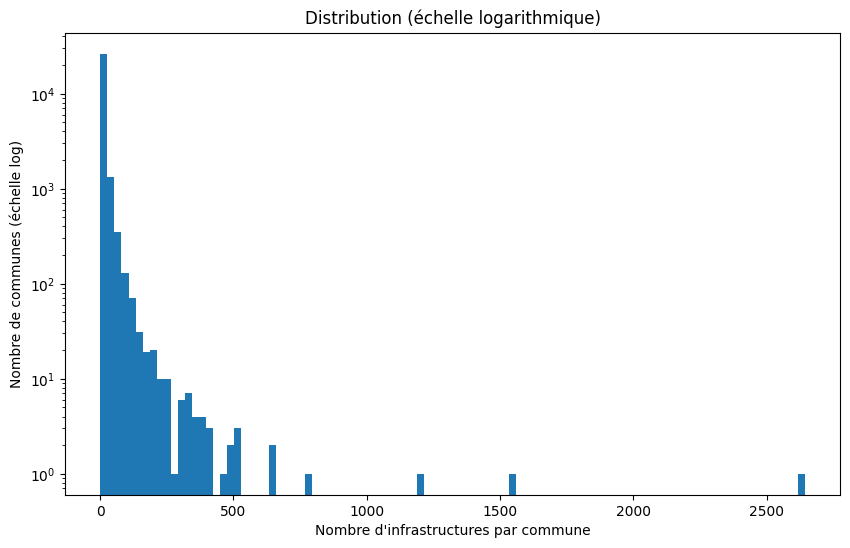

In [36]:
plt.figure(figsize=(10,6))
plt.hist(infra_par_commune["Nombre d'infrastructures par commune"], bins=100)
plt.yscale("log")
plt.xlabel("Nombre d'infrastructures par commune")
plt.ylabel("Nombre de communes (échelle log)")
plt.title("Distribution (échelle logarithmique)")
plt.show()

Le graphique obtenu ressemble la densité d'une loi exponentielle : toutes les valeurs sont positives mais la décroissance est très forte avec juste quelques extrêmes.

In [37]:
infra_par_densite = (
    df_final.copy().groupby("dens_lib")
            .size()
            .reset_index(name="Nombre d'infrastructures")
)
infra_par_densite = infra_par_densite.sort_values("Nombre d'infrastructures", ascending=False)
infra_par_densite

,dens_lib,Nombre d'infrastructures
5,Rural à habitat dispersé,73613
0,Bourgs ruraux,62632
3,Grands centres urbains,54623
2,Centres urbains intermédiaires,30300
1,Ceintures urbaines,26753
4,Petites villes,20453
6,Rural à habitat très dispersé,16838


Selon la classification de l’INSEE, les communes rurales concentrent le plus grand nombre d’infrastructures sportives en valeur absolue, notamment les catégories « Rural à habitat dispersé » et « Bourgs ruraux ». Ce résultat s’explique principalement par le fait que les communes rurales représentent la grande majorité des communes françaises. Les grands centres urbains totalisent également beaucoup d’équipements, mais restent derrière car ils sont moins nombreux. Ainsi, cette répartition reflète surtout le nombre de communes par catégorie, davantage que leur niveau réel d’équipement moyen.

In [38]:
def tab_barplot(df, titre):
    """
    Affiche un graphique et un tableau côte à côte à partir d'un DataFrame à 2 colonnes
    
    Paramètre
    ----------
    df : DataFrame
        DataFrame à deux colonnes
        
    titre : str
        Titre de la figure
    """
    fig = plt.figure(figsize = (16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)


    #Création du barplot
    ax1.bar(
    df[df.columns[0]], 
    df[df.columns[1]]
    )
    ax1.set_xlabel(df.columns[0])
    ax1.set_ylabel(df.columns[1])



    #Création du tableau
    ax2.axis('off')

    table = ax2.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.4, 0.6]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2) 

    fig.suptitle(titre)

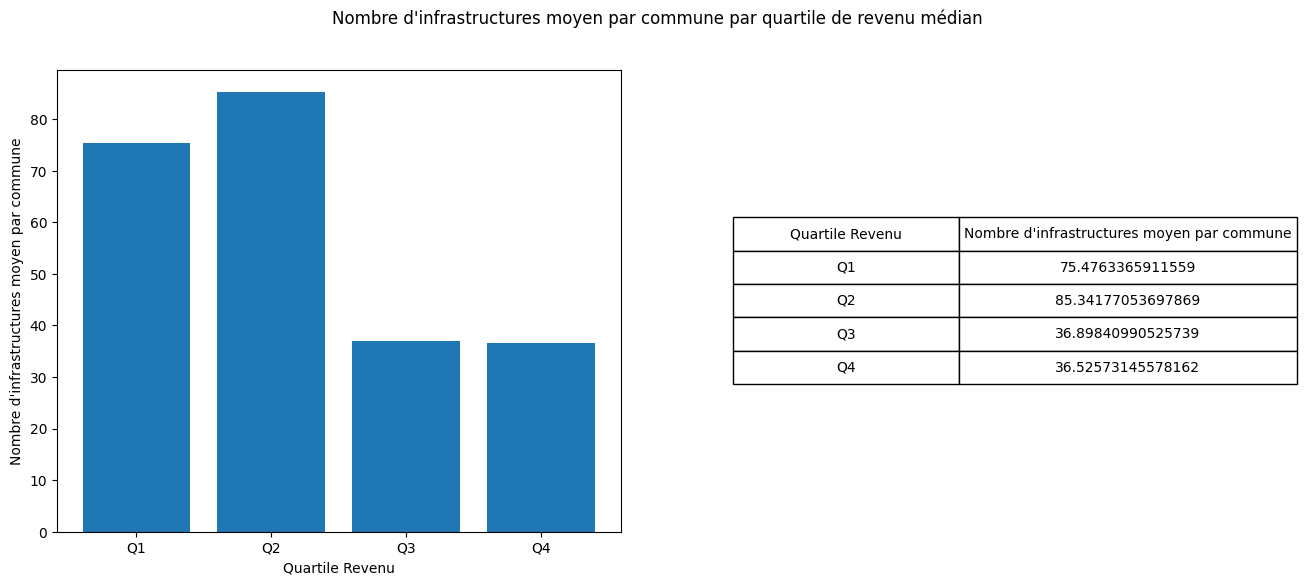

In [39]:
df_med = infra_par_commune.merge(
    df_final.copy()[["new_name", "MED21"]],
    on= "new_name",
    how="left"
)


df_med["Quartile Revenu"] = pd.qcut(
    df_med["MED21"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile = (
    df_med.groupby("Quartile Revenu", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_quartile.columns = ["Quartile Revenu", "Nombre d'infrastructures moyen par commune"]

tab_barplot(infra_par_quartile, "Nombre d'infrastructures moyen par commune par quartile de revenu médian")

D’après la distribution en quartiles du revenu médian des communes, on observe une relation contrastée entre niveau de vie et nombre d’infrastructures sportives. Les communes situées dans les quartiles Q1 et Q2 - les territoires les plus modestes - disposent en moyenne du plus grand nombre d’équipements, autour de 80 à 90 infrastructures par commune. À l’inverse, les communes appartenant aux quartiles Q3 et surtout Q4 (les plus aisées) présentent des moyennes nettement plus faibles, autour de 40 infrastructures. Cette répartition suggère que les territoires moins favorisés accueillent proportionnellement davantage d’infrastructures sportives que les plus riches, sans doute en raison de leur poids démographique ou de logiques d’aménagement spécifiques.

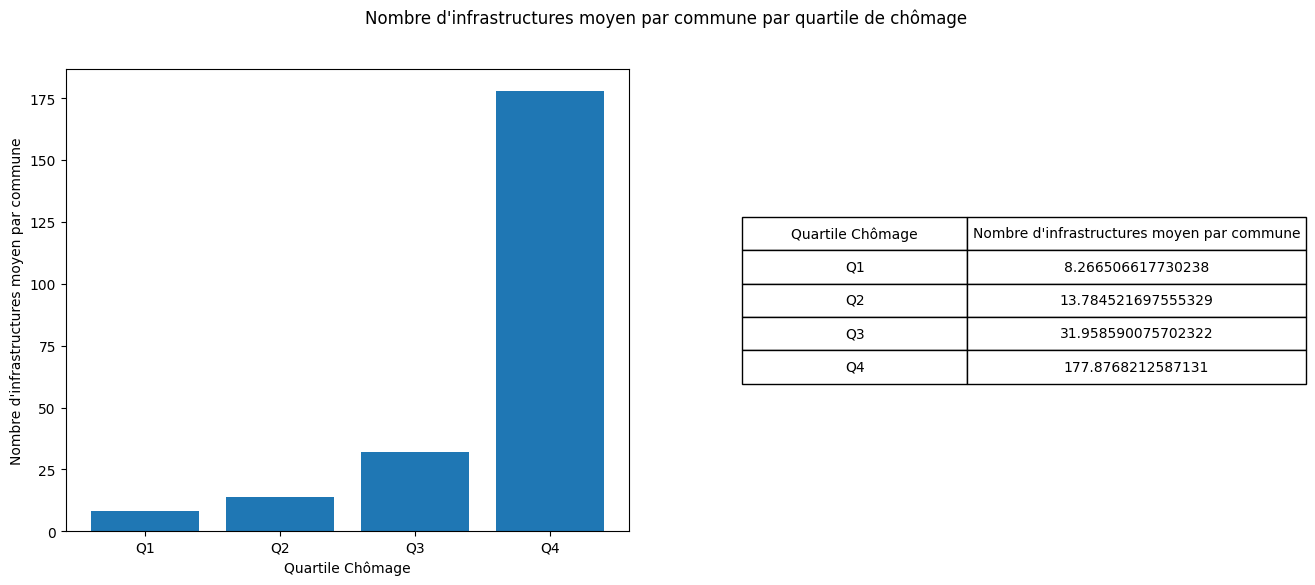

In [40]:
df_chom = infra_par_commune.merge(
    df_final.copy()[["new_name", "P22_CHOM1564"]],
    on= "new_name",
    how="left"
)


df_chom["Quartile Chômage"] = pd.qcut(
    df_chom["P22_CHOM1564"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile_chom = (
    df_chom.groupby("Quartile Chômage", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_quartile_chom.columns = ["Quartile Chômage", "Nombre d'infrastructures moyen par commune"]
tab_barplot(infra_par_quartile_chom, "Nombre d'infrastructures moyen par commune par quartile de chômage")

L’analyse par quartiles du taux de chômage montre une relation positive similaire à celle observée avec le revenu médian. Ici, les communes les plus touchées par le chômage (quartile Q4) concentrent en moyenne beaucoup plus d’infrastructures sportives, près de 170 par commune, contre seulement 8 à 14 dans les quartiles les plus faibles (Q1–Q2). L’étude du revenu médian révélait de la même manière que les communes les plus aisées étaient plutôt moins dotées en infrastructures. Ces résultats suggèrent qu’une partie importante de l’offre sportive se situe dans des territoires plus fragiles socio-économiquement, où le niveau de chômage est élevé et les revenus plus faibles.

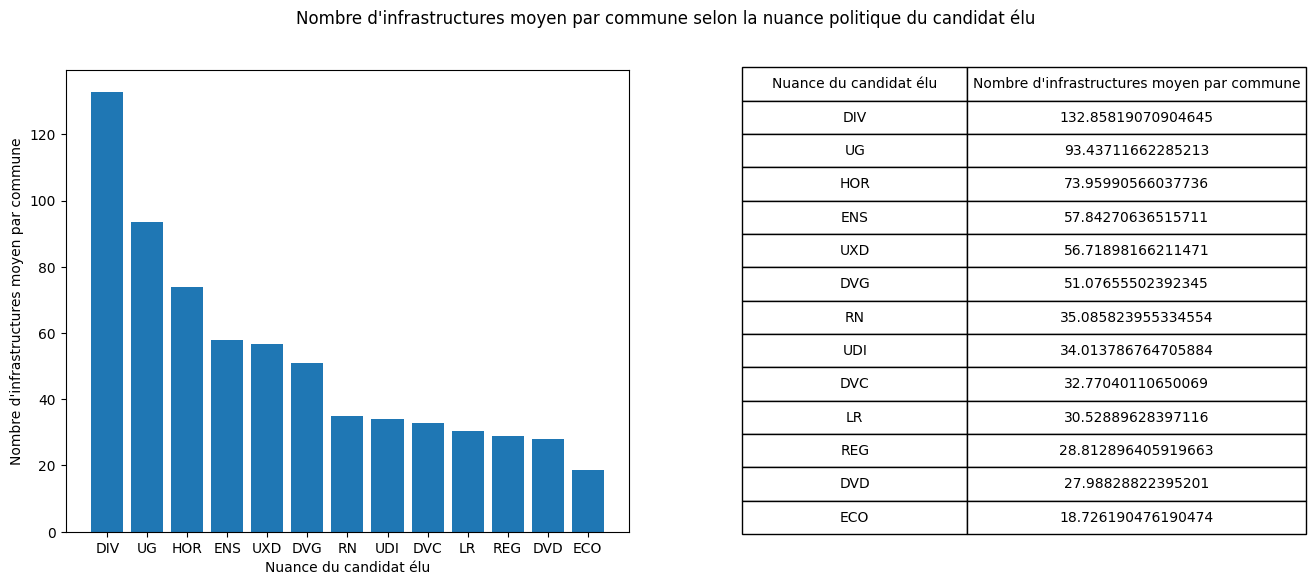

In [41]:
df_pol = infra_par_commune.merge(
    df_final.copy()[["new_name", "Nuance candidat élu"]],
    on= "new_name",
    how="left"
)


infra_par_pol= (
    df_pol.groupby("Nuance candidat élu", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_pol.columns = ["Nuance du candidat élu", "Nombre d'infrastructures moyen par commune"]
infra_par_pol = infra_par_pol.sort_values("Nombre d'infrastructures moyen par commune", ascending=False)

tab_barplot(infra_par_pol, "Nombre d'infrastructures moyen par commune selon la nuance politique du candidat élu")

La comparaison du nombre moyen d’infrastructures sportives selon la nuance du candidat élu en 2024 montre des écarts importants entre territoires. Les communes ayant élu un candidat classé DIV, UG ou HOR apparaissent en moyenne nettement plus dotées en équipements que celles administrées par des élus LR, REG, DVD ou ECO. Toutefois, cette lecture doit être fortement nuancée : l’élection de 2024 n’a eu quasiment aucun impact sur la présence d’infrastructures sportives, puisque celles-ci résultent d’investissements réalisés sur de longues périodes. Les différences observées reflètent donc avant tout les caractéristiques socio-économiques des territoires où ces nuances politiques sont dominantes, plutôt qu’un effet direct de l’orientation politique des élus élus en 2024.

### IV/ Modélisation


In [42]:
#On transforme notre base de données pour faire des régressions

infra_count = df_final.groupby('new_code').size().reset_index(name='Nb_infrastructures')

autres_vars = df_final.groupby('new_code').first().reset_index()

df_commune = autres_vars.merge(infra_count, on='new_code', how='left')

df_commune.head(6)


,new_code,inst_cp,new_name,dep_code,aps_name,dens_lib,equip_type_name,equip_x,equip_y,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu,Nb_infrastructures
0,01001,1400,L'Abergement-Clémenciat,1,"Pétanque et jeu provencal,Sports boules",Rural à habitat dispersé,Terrain de boules,4.920558,46.152746,859.0,354.000000,25820,s,28.000000,RN,6
1,01002,1640,L'Abergement-de-Varey,1,Spéléologie,Rural à habitat dispersé,Espace de pratique spéléologique,5.425750,46.005410,273.0,121.000000,24480,s,2.000000,UXD,1
2,01004,1500,Ambérieu-en-Bugey,1,Tennis de table,Centres urbains intermédiaires,Salle de tennis de table,5.337220,45.955270,15554.0,7107.012476,21660,"17,0",1005.744641,UXD,53
3,01005,1330,Ambérieux-en-Dombes,1,Football / Football en salle (Futsal),Bourgs ruraux,Terrain de football,4.901900,45.991700,1917.0,814.669985,24610,s,63.323397,RN,12
4,01006,1300,Ambléon,1,Spéléologie,Rural à habitat dispersé,Espace de pratique spéléologique,5.601380,45.749440,114.0,57.000000,24210,s,5.000000,ENS,1
5,01007,1500,Ambronay,1,Football / Football en salle (Futsal),Rural à habitat dispersé,Terrain de football,5.348210,46.005740,2828.0,1207.205453,24860,s,105.671492,UXD,15


In [43]:
#On renomme les variables pour ne pas avoir d'erreurs avec statsmodels (accents et espaces)
df_commune = df_commune.rename(columns={
    "Nuance candidat élu": "Nuance_candidat",
    "dens_lib": "Densite"
})

In [44]:
#Determinants du nombre d'infrastructures
model = smf.ols('Nb_infrastructures ~ P22_POP + MED21 + C(Nuance_candidat) + C(Densite)', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     532.1
Date:                Sat, 27 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:58:49   Log-Likelihood:                -91078.
No. Observations:               24095   AIC:                         1.822e+05
Df Residuals:                   24074   BIC:                         1.824e+05
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

L’analyse montre que la couleur politique du député élu en 2024 n’a pas d’impact significatif sur le nombre d’infrastructures sportives, ce qui s’explique par des décisions d’aménagement prises sur le long terme.​
En revanche, la densité du territoire apparaît comme un facteur déterminant dans plusieurs types d’espaces (urbains et ruraux), influençant la répartition des équipements.
La population en 2022 joue également un rôle majeur : plus un territoire compte d’habitants, plus il tend à disposer d’un parc sportif développé. 
Le revenu médian de 2021 intervient lui aussi car le modèle prédit qu'une hausse de 1€ du revenu médian diminue le nombre d'infrastructures d'une commune de 0,0004. 

Concentrons nous sur ces 2 dernières variables:

In [45]:
model2 = smf.ols('Nb_infrastructures ~ P22_POP + MED21', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité

print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     119.2
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           3.22e-52
Time:                        14:58:49   Log-Likelihood:                -92436.
No. Observations:               24095   AIC:                         1.849e+05
Df Residuals:                   24092   BIC:                         1.849e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4099      0.549     18.961      0.0

On constate qu'à eux seuls, le revenu médian de 2021 et la population en 2022 expliquent 78% des infrastructures sportives en France. On peut, à partir de ces deux variables, construire une carte théorique des équipements sportifs en France.

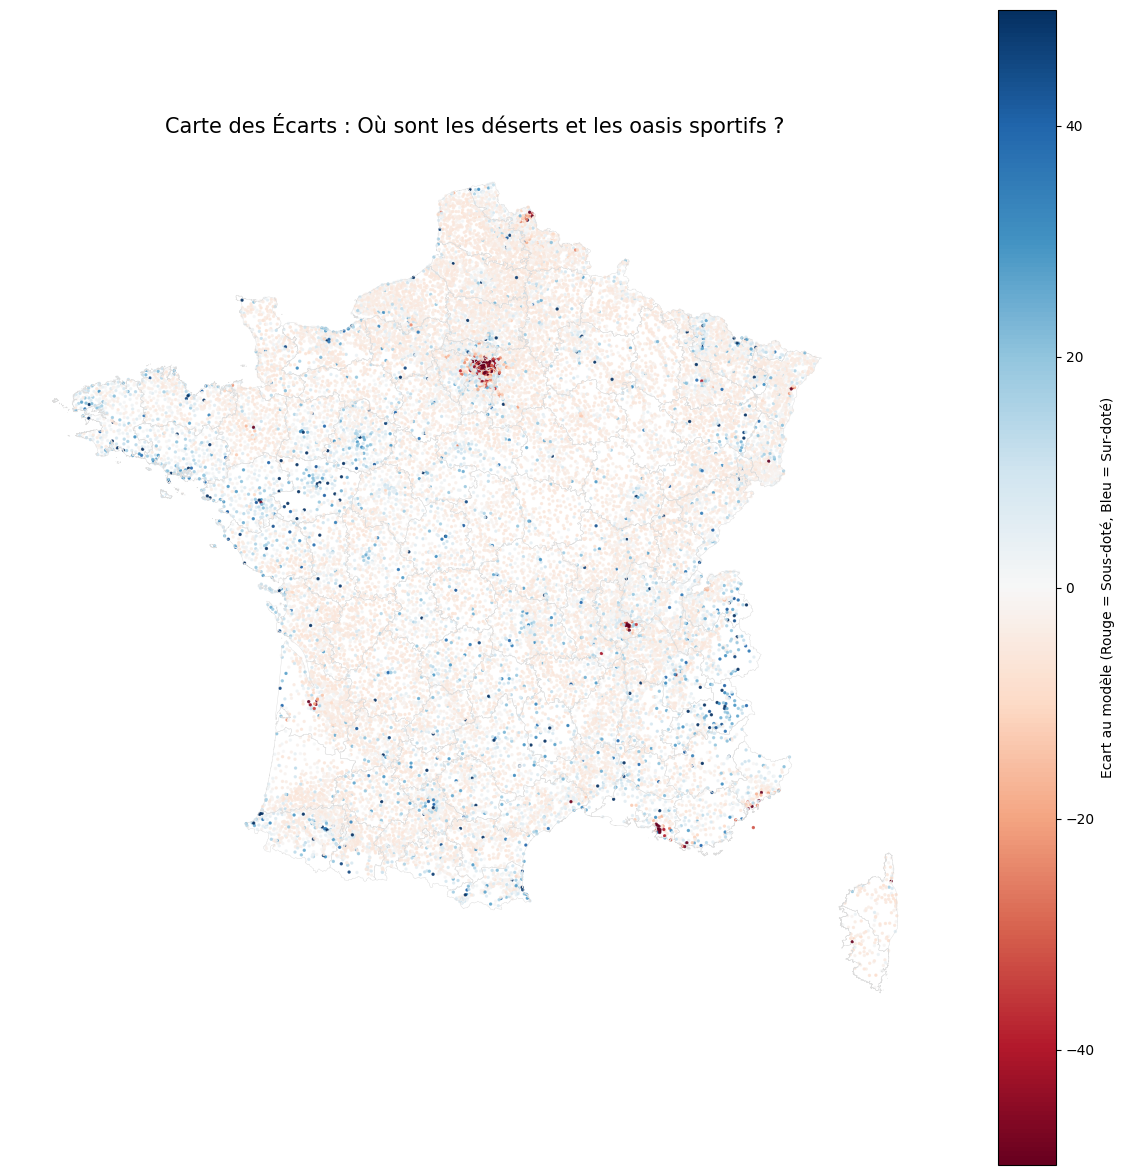

In [46]:
df_reg = df_final.groupby("new_code").agg({
    "new_code": "count",       
    "P22_POP": "first",       
    "MED21": "first",         
    "equip_x": "first",       
    "equip_y": "first"
}).rename(columns={"new_code": "nb_reel"}).reset_index()

df_reg = df_reg.dropna(subset=["P22_POP", "MED21"])

df_reg["nb_theorique"] = 10.4022 + (0.0023 * df_reg["P22_POP"]) - (0.0002 * df_reg["MED21"])

df_reg["ecart"] = df_reg["nb_reel"] - df_reg["nb_theorique"]

gdf_analyse = gpd.GeoDataFrame(
    df_reg,
    geometry=gpd.points_from_xy(df_reg["equip_x"], df_reg["equip_y"]),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(15, 15))
gdf.boundary.plot(ax=ax, linewidth=0.3, color="gray") # Fond de carte
gdf_analyse.plot(
    ax=ax,
    column="nb_theorique",
    cmap="viridis",
    markersize=2,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': "Nombre d'équipements prédit par le modèle"}
)
ax.set_title("Carte Théorique : Équipements prédits par la Population et le Revenu", fontsize=15)
ax.set_axis_off()
plt.savefig('docs/carte_theorique.png', dpi=300, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(figsize=(15, 15))
gdf.boundary.plot(ax=ax, linewidth=0.3, color="#dddddd")

gdf_analyse.plot(
    ax=ax,
    column="ecart",
    cmap="RdBu",  # Rouge = Moins que prévu / Bleu = Plus que prévu
    vmin=-50,     
    vmax=50,
    markersize=2,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Ecart au modèle (Rouge = Sous-doté, Bleu = Sur-doté)"}
)
ax.set_title("Carte des Écarts : Où sont les déserts et les oasis sportifs ?", fontsize=15)
ax.set_axis_off()
plt.savefig('docs/carte_ecarts.png', dpi=300, bbox_inches='tight')


Si on se concentre sur cette carte des écarts entre théorie et réalité, on constate que les grandes villes (Paris, Marseille, Bordeaux, Lyon, Lille etc.) sont sous-dotées en équipements sportifs par rapport à leur population et à leur revenu médian.

Au contraire, on constate que les littoraux et les zones montagneuses sont sur-dotées. Cela peut s'expliquer par le tourisme, qui rend nécessaire la création d'infrastructures supplémentaires. 

Si on se concentre que sur la population, on voit que celle-ci explique à elle seule la plupart de la répartition des infrastructures en France métropolitaine ($R^2$ = 0.75).

In [47]:
model3 = smf.ols('Nb_infrastructures ~ P22_POP', data = df_commune).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     246.5
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           2.60e-55
Time:                        14:58:57   Log-Likelihood:            -1.0928e+05
No. Observations:               28264   AIC:                         2.186e+05
Df Residuals:                   28262   BIC:                         2.186e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2616      0.272     19.349      0.0

Text(0.5, 1.0, "Représentation graphique de la régression linéaire du nombre d'infrastructures sur la population")

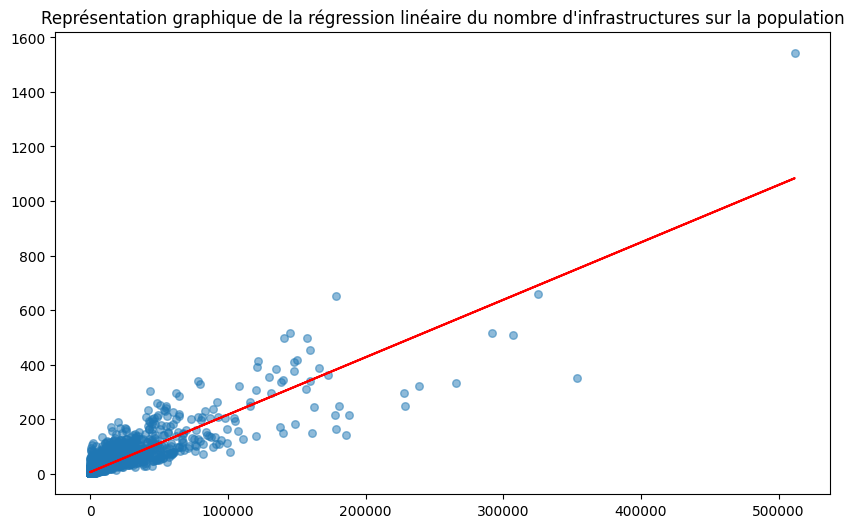

In [48]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1, 1, 1)

# Nuage de points
ax.scatter(df_commune['P22_POP'], df_commune['Nb_infrastructures'], 
           alpha=0.5, s=30, label='Observations')
ax.plot(df_commune['P22_POP'].dropna(), model3.predict(), color = "Red", label = "Droite de régression")
ax.set_title("Représentation graphique de la régression linéaire du nombre d'infrastructures sur la population")


In [49]:
!nb-clean clean main.ipynb
!ls -lh main.ipynb

-rw-r--r-- 1 onyxia users 48K Dec 27 14:58 main.ipynb


## Conclusion

L’analyse spatiale et socio-économique des infrastructures sportives en France révèle une distribution qui bouscule les idées reçues, mettant en lumière un paradoxe entre richesse et équipement.

Il apparaît que les territoires les plus fragiles économiquement sont, en moyenne, les mieux dotés : les communes subissant le plus fort taux de chômage et celles aux revenus les plus modestes concentrent une part prépondérante de l’offre sportive. 

À l’inverse, les communes les plus aisées affichent un niveau d’équipement nettement plus faible, suggérant que l’investissement sportif a été historiquement mobilisé comme un levier de cohésion sociale dans les territoires populaires.

Cette dynamique doit cependant être analysée à l'aune d'un facteur déterminant : la démographie. L'utilisation d'un modèle de régression linéaire confirme que la taille de la population est le moteur principal de l'équipement. Avec un coefficient de détermination $R^2 = 0,75$, on établit que 75 % de la variation du nombre d’infrastructures s'explique uniquement par le nombre d'habitants. Ce résultat mathématique relativise les autres variables : si les communes les plus pauvres ou les zones rurales semblent mieux dotées en valeur absolue, c'est avant tout parce qu'elles couvrent des bassins de vie dont la masse critique de population justifie ces équipements. 

Ce poids démographique explique également pourquoi la lecture politique des territoires doit être prudente. Si les communes ayant élu des candidats DIV, UG ou HOR en 2024 apparaissent mieux pourvues, cela témoigne davantage de la sociologie urbaine et dense de ces circonscriptions que d'un effet direct du dernier scrutin. 

Enfin, l'étude des écarts entre théorie et réalité souligne une fracture territoriale majeure. En raison de cette corrélation à 75 %, les grandes métropoles (Paris, Lyon, Marseille) se retrouvent paradoxalement sous-dotées (déserts sportifs) face à l'immensité de leur population, tandis que les zones de montagne et les littoraux bénéficient d'un surplus d'équipements (oasis sportifs), dimensionnés pour les flux saisonniers plutôt que pour les seuls résidents permanents. 